# Lab 1 : Spatial Autocorrelation

In this lab, we explore the measurement of spatial autocorrelation by Moran's index. We will use both R in this notebook and a package called GeoDa (installed on the lab computers) to do this. Each has advantages. We suggest you work in this notebook to the point where you might begin to find the code involved a bit bewildering. It's OK if that happens, don't panic, and switch to GeoDa. 

Even if you don't get pushed past your tolerance for code, you are encouraged to also explore the application of these measures using GeoDa.

In [1]:
# We import our libraries here

library(spdep)
library(classInt)
library(rgdal)
library(RColorBrewer)

Loading required package: sp
Loading required package: Matrix
rgdal: version: 1.2-16, (SVN revision 701)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.1.3, released 2017/20/01
 Path to GDAL shared files: /Library/Frameworks/GDAL.framework/Versions/2.1/Resources/gdal
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 4.9.1, 04 March 2015, [PJ_VERSION: 491]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.2-5 


## Read in the data and take a look at it

Read the shape file from the data directory

In [2]:
auck <- readOGR("data/ak-TB-ethnicity-0506.shp", integer64="allow.loss")

OGR data source with driver: ESRI Shapefile 
Source: "data/ak-TB-ethnicity-0506.shp", layer: "ak-TB-ethnicity-0506"
with 318 features
It has 12 fields


In [3]:
# Let's see a summary of our spatial data
summary(auck)

Object of class SpatialPolygonsDataFrame
Coordinates:
      min     max
x 2638999 2713900
y 6449610 6503050
Is projected: TRUE 
proj4string :
[+proj=nzmg +lat_0=-41 +lon_0=173 +x_0=2510000 +y_0=6023150
+datum=nzgd49 +units=m +no_defs +ellps=intl
+towgs84=59.47,-5.04,187.44,0.47,-0.1,1.024,-4.5993]
Data attributes:
    OBJECTID           AU_NAME      SHAPE_LENG       SHAPE_AREA       
 1      :  1   Abbotts Park:  1   Min.   :  2273   Min.   :   199484  
 10     :  1   Aberfeldy   :  1   1st Qu.:  5186   1st Qu.:  1063873  
 100    :  1   Akarana     :  1   Median :  6234   Median :  1501853  
 101    :  1   Albany      :  1   Mean   :  9148   Mean   :  4445327  
 102    :  1   Ambury      :  1   3rd Qu.:  8219   3rd Qu.:  2097003  
 103    :  1   Aorere      :  1   Max.   :142920   Max.   :204233182  
 (Other):312   (Other)     :312                                       
     AU_NO           TB_CASES         TB_RATE           TOT_06    
 Min.   :506901   Min.   : 0.000   Min.   :  0.00

In [4]:
#names function gives you the header (first row) of your data
names(auck)

[1] "OBJECTID"   "AU_NAME"    "SHAPE_LENG" "SHAPE_AREA" "AU_NO"     
 [6] "TB_CASES"   "TB_RATE"    "TOT_06"     "EUR_P_06"   "MAO_P_06"  
[11] "PAC_P_06"   "ASI_P_06"

In [5]:
#The data frame -> row and header of data, in "tabular" format
#let's make df the dataframe
df <- data.frame(auck)
nrow(df)
head(df, n=10)

[1] 318

,OBJECTID,AU_NAME,SHAPE_LENG,SHAPE_AREA,AU_NO,TB_CASES,TB_RATE,TOT_06,EUR_P_06,MAO_P_06,PAC_P_06,ASI_P_06
0,1,North Harbour East,10497.337,5167324,508807,4,108.3,3693,60,3.9,0.97,26.0
1,2,North Harbour West,12351.507,2882323,508806,1,33.9,2949,58,4.8,1.00,27.0
2,3,Windsor Park,6603.966,2686065,508805,0,0.0,1800,56,2.7,1.20,32.0
3,4,Half Moon Bay,5951.116,1249048,522730,2,58.3,3432,67,4.3,1.60,20.0
4,5,Pinehill,5387.856,1634537,508804,0,0.0,2700,43,2.2,1.20,46.0
5,6,Herald,12571.814,1909593,513420,1,58.9,1698,77,6.0,3.40,3.5
6,7,Unsworth Heights,6118.736,1809426,508803,1,19.3,5169,51,5.7,2.80,29.0
7,8,Otimai,19356.538,14988120,512902,0,0.0,2508,81,6.0,1.20,1.4
8,9,Parrs Park,9899.108,3659348,512901,3,48.4,6198,48,15.0,26.00,13.0
9,10,Green Bay,7936.118,2169151,512100,4,101.6,3936,71,8.1,6.30,10.0


## Exploring the data in maps

As in the previous lab, we will make some choropleth maps to examine the various data of possible interest in this setting. To make this a bit less arduous, here is that simple choropleth mapping function from the previous notebook, which you can use to make maps of the different variables of interest. 

In [6]:
# Definition of a function to automate a series of commands and make a choropleth map
choro <- function(sf, varname, nclasses=5, pal='Reds', sty='equal', ttl=varname) {
    palette <- brewer.pal(nclasses, pal)
    classes <- classIntervals(sf[[varname]], nclasses, style=sty)
    colors <- findColours(classes, palette)
    plot(sf, col=colors, lwd=0.2)
    legend('top', ncol=3, legend=names(attr(colors, 'table')), fill=attr(colors, 'palette'), cex=0.8, bty='n')
    title(ttl)
}

Principally we want you to look at the tuberculosis rate (in cases per 100,000 population) `TB_RATE`,  and also at the different distributions of the various census-defined ethnic groups, NZ European `EUR_06`, Māori `MAO_06`, Pasifika `PAC_06`, Asian `ASI_P_06`, and Middle-eastern and Latin American (inccongruously combined in NZ census data, `MEL_06`), and 'Other' `OTH_06`. You need really only pay attention to the tuberculosis rate, and to the four major population groupings here, European, Māori, Pasifika, and Asian.

Use the above function in the cell below, to map the tuberculosis rate.

Don't forget that you have options for changing the map colors (`pal`), the number of classes (`nclasses`) and the classification method (`sty`) in this map and others you make.

In [7]:
# Put a line of code here to map the tuberculosis rate data

Use the cell below to map all four of the major population groups. idea you might explore is to make all four of the ethnicity/race distribution maps in single display, by first issuing the `par(mfrow=c(2,2))` command, which will set up the display area for a 2 by 2 grid of maps. Then make four distinct maps.

In [8]:
# this line sets up the graphic display for a two by two array of plots
# with narrower margins of 0.1 of the overall display area
par(mfrow=c(2,2), mai=rep(0.1,4))
# write a line of code to make a map
# write a line to make another map
# and another
# and then a fourth one

# Graphing the data

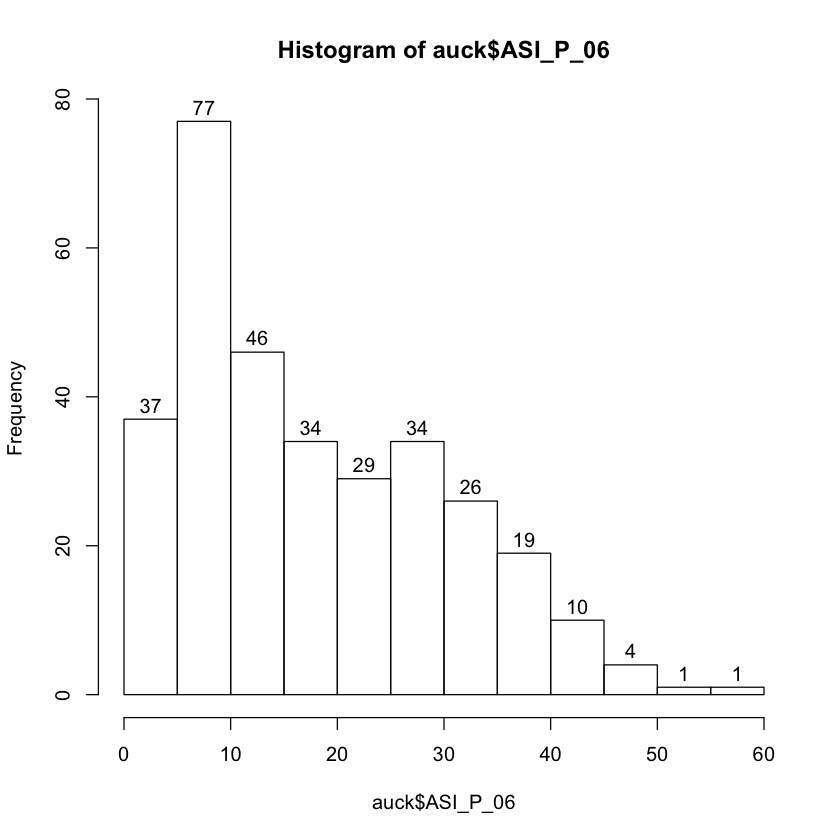

In [9]:
hist(auck$ASI_P_06, labels=T)

# Spatial autocorrelation

The focus of this lab is on measuring spatial autocorrelation. We are going to do this with the aim of identifying where the most clear clusters ('high-high') of high tuberculosis rates are to be found based on the data available. We will start with a simple autocorrelation analysis, and then proceed to the more complex business of local Moran's analysis, which is what we need to identify cluster locations.

The goal then is to relate the cluster locations, at least qualitatively to the different population distributions (mapped in the previous sections) and answer some questions that follow.

### Nearness - setting up the neighborhood structure
Here we will use the simplest possible definition of neighbors based on polygon contiguity. More elaborate concepts of 'nearness' can be explored using GeoDa.

In [10]:
# Generate the weight matrix
# queen = False option means at least two boundary points must be 
# within the snap distance of each other
# with the conventional name of a ‘rook’ relationship.
# The snap option is the same as precision threshold in geoda

nb <- poly2nb(auck, row.names=auck$FIRST_CAU_, queen=FALSE, snap=1e-05)
length(nb)


[1] 318

In [11]:
#example of the first polygon in w, numbers are the neighbors for the first polygon
nb[1]
auck$AU_NAME[1]

#make a summary of w
summary(nb)

[[1]]
[1]   2   3   5   7 146 154

[1] North Harbour East
318 Levels: Abbotts Park Aberfeldy Akarana Albany Ambury Aorere ... Woodglen

Neighbour list object:
Number of regions: 318 
Number of nonzero links: 1488 
Percentage nonzero weights: 1.471461 
Average number of links: 4.679245 
1 region with no links:
131
Link number distribution:

 0  1  2  3  4  5  6  7  8  9 11 12 
 1  6 21 40 83 79 51 19 13  3  1  1 
6 least connected regions:
5 40 74 207 213 270 with 1 link
1 most connected region:
303 with 12 links


#### How many regions are there with no links?

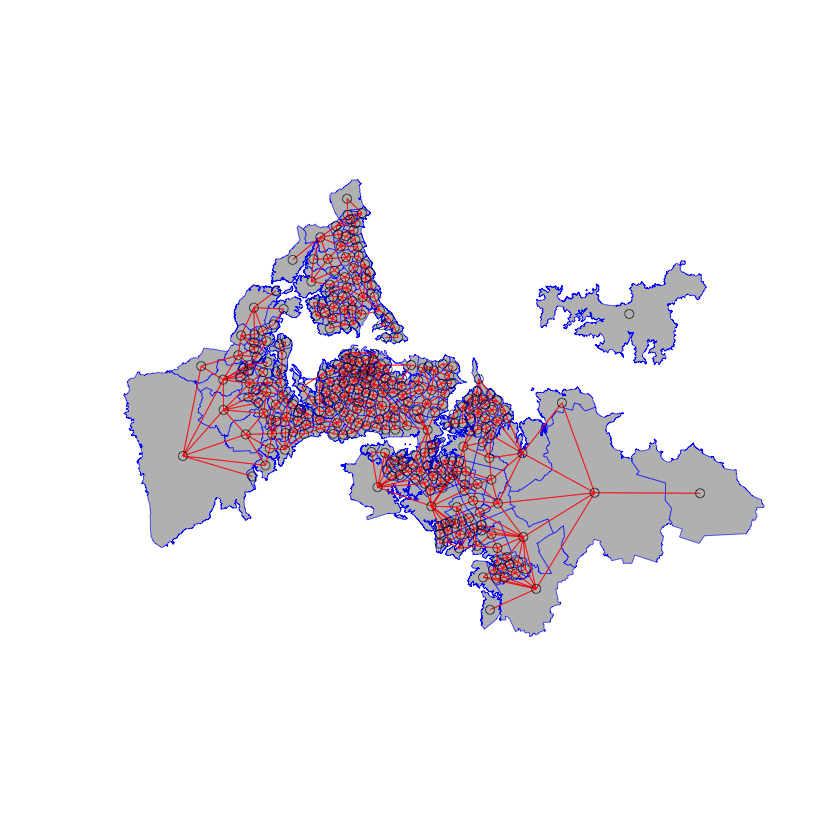

In [12]:
plot(auck, col='gray', border='blue', lwd=0.5)
xy <- coordinates(auck)
plot(nb, xy, col='red', lwd=0.5, add=TRUE)

## Moran's *I* in equation form

$I = \frac{n}{\sum_{i=1}^n (y_i - \bar{y})^2} \frac{\sum_{i=1}^n \sum_{j=1}^n w_{ij}(y_i - \bar{y})(y_j - \bar{y})}{\sum_{i=1}^n \sum_{j=1}^n w_{ij}}$

In [13]:
# Let's first see what manual computation of Moran's I looks like.
# This part is optional, but feel free to uncomment the lines 
# needed to run the manual calculation

# 1. n is the number of observations (length of our dataset)
# n <- length(auck)

# 2. we set y to the column of PC_ASIAN, then we get the mean.
# y <- auck$PC_ASIAN
# ybar <- mean(y)

# 3. find the difference between y and ybar(the mean)
# dy <- y - ybar
# yi <- rep(dy, each=n)
# yj <- rep(dy)
# yiyj <- yi * yj

# pm <- matrix(yiyj, ncol=n)

# pmw <- pm * wm

# spmw <- sum(pmw)

# smw <- sum(wm)
# sw  <- spmw / smw
# vr <- n / sum(dy^2)
# MI <- vr * sw

# 4. Morans I
# cat("Moran's I is", MI)

In [14]:
# let's make a weights object so that we 
# can use it with a less manual way of computing moran's i
lw <- nb2listw(nb, style="W", zero.policy=TRUE)
print(lw, zero.policy=TRUE)

Characteristics of weights list object:
Neighbour list object:
Number of regions: 318 
Number of nonzero links: 1488 
Percentage nonzero weights: 1.471461 
Average number of links: 4.679245 
1 region with no links:
131

Weights style: W 
Weights constants summary:
    n     nn  S0       S1       S2
W 317 100489 317 148.8196 1313.621


In [15]:
summary(lw, zero.policy=TRUE)

Characteristics of weights list object:
Neighbour list object:
Number of regions: 318 
Number of nonzero links: 1488 
Percentage nonzero weights: 1.471461 
Average number of links: 4.679245 
1 region with no links:
131
Link number distribution:

 0  1  2  3  4  5  6  7  8  9 11 12 
 1  6 21 40 83 79 51 19 13  3  1  1 
6 least connected regions:
5 40 74 207 213 270 with 1 link
1 most connected region:
303 with 12 links

Weights style: W 
Weights constants summary:
    n     nn  S0       S1       S2
W 317 100489 317 148.8196 1313.621


In [16]:

m_scatterplot <- function (sf, varname, listweights, ttl='', linecol='red') {
    
scaled_col <<- paste('s', varname, sep='')
lagged_col <<- paste('lag_', varname, sep='')
print(scaled_col)
print(lagged_col)

sf[[scaled_col]] <- scale(sf[[varname]]) 
    
sf[[lagged_col]] <- lag.listw(listweights, sf[[scaled_col]], zero.policy=TRUE)
    
plot(x=sf[[scaled_col]], y=sf[[lagged_col]], xlab=scaled_col, ylab=lagged_col, main=ttl)
    
abline(h=0, v=0)
best_fit_line <- lm(sf[[lagged_col]] ~ sf[[scaled_col]])
abline(best_fit_line, lty=2, lwd=1, col=linecol)
    
#Note that the slope of the regression line 
# is nearly the same as Moran's I
coefficients(best_fit_line)[2]
    
# Save new columns into the shapefile
assign('auck',sf, envir=.GlobalEnv)
}

[1] "sASI_P_06"
[1] "lag_ASI_P_06"


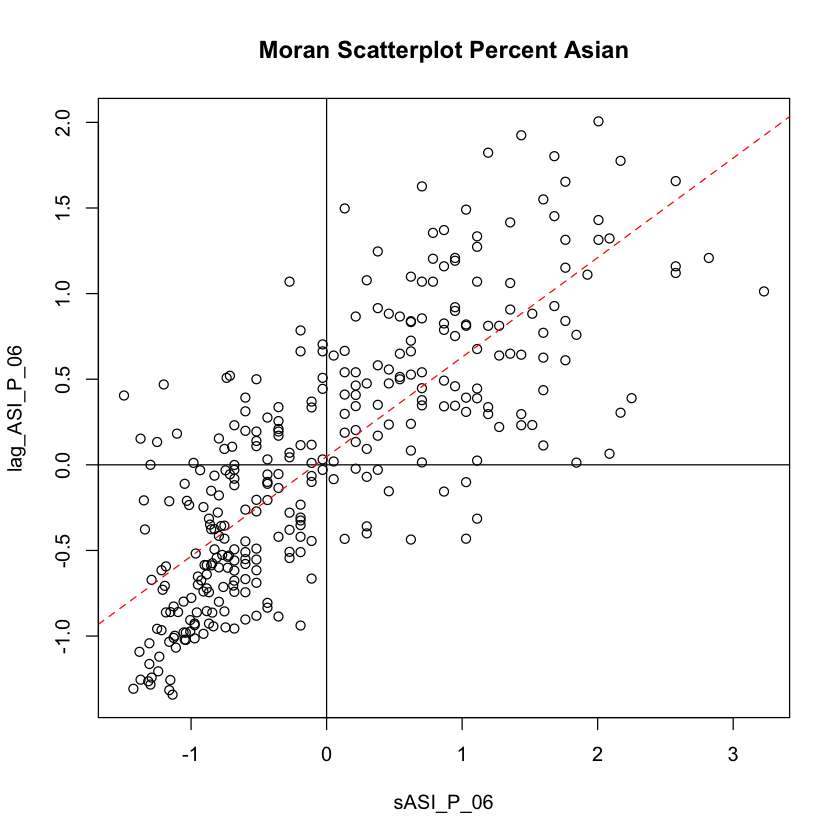

In [17]:
#Call the function to make the plot
m_scatterplot(auck, 'ASI_P_06', lw, ttl='Moran Scatterplot Percent Asian', linecol='red')

#### How did we change our shapefile?

Let's look at the table format again, with the head() function

In [18]:
# head(auck@data, n=10)

In [19]:
moran(auck$ASI_P_06, lw, n=length(lw$neighbours), S0=Szero(lw), NAOK=TRUE, zero.policy=TRUE)

$I
[1] 0.5831851

$K
[1] 2.627293

In [20]:
moran.test(auck$ASI_P_06, lw, randomisation=FALSE, zero.policy=TRUE)


	Moran I test under normality

data:  auck$ASI_P_06  
weights: lw  

Moran I statistic standard deviate = 15.3, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.581351160      -0.003164557       0.001459571 


In [21]:
mmc <- moran.mc(auck$ASI_P_06, lw, nsim=999, zero.policy=TRUE)

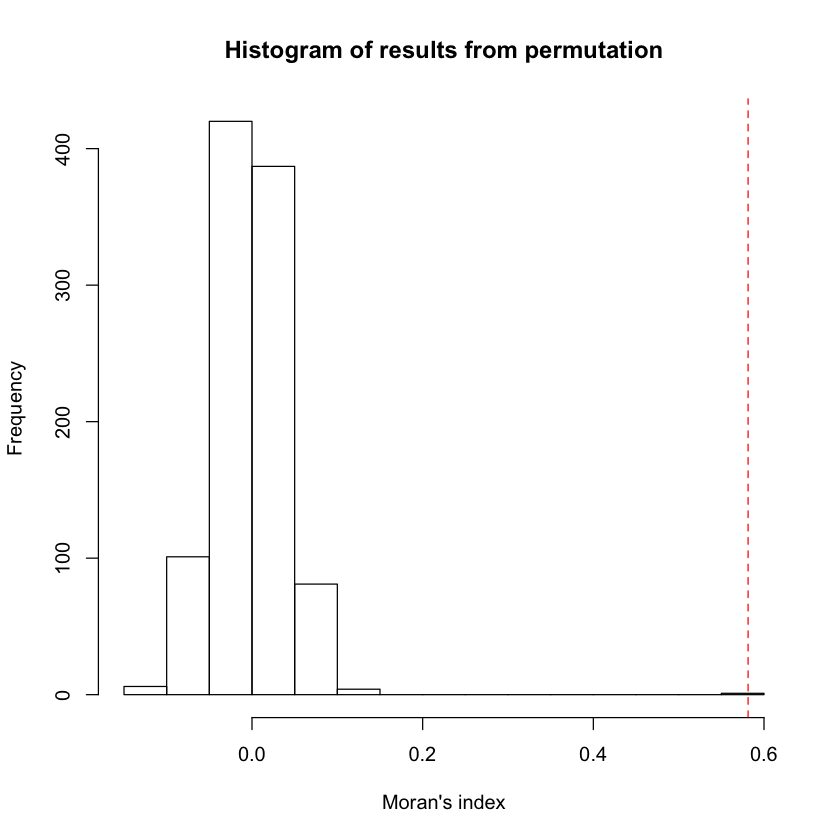

In [22]:
hist(mmc$res, main="Histogram of results from permutation", xlab="Moran's index")
abline(v=mmc$statistic, col='red', lty=2)

# Univariate Local Moran’s I

Local Moran is defined as:

$I_i = \frac{(x_i-\bar{x})}{{\sum_{k=1}^{n}(x_k-\bar{x})^2}/(n-1)}{\sum_{j=1}^{n}w_{ij}(x_j-\bar{x})}$

In [23]:
# We use the localmoran function instead of moran
# let's title our results "locm_asi_p_o6" for clarity
locm_asi_p_06 <- localmoran(auck$ASI_P_06, lw, alternative="two.sided")
summary(locm_asi_p_06, NAOK = TRUE)

Warning message in lag.listw(listw, z, zero.policy = zero.policy, NAOK = NAOK):
“NAs in lagged values”

       Ii                E.Ii               Var.Ii            Z.Ii        
 Min.   :-0.60712   Min.   :-0.003155   Min.   :0.0000   Min.   :-1.6134  
 1st Qu.: 0.05193   1st Qu.:-0.003155   1st Qu.:0.1632   1st Qu.: 0.1162  
 Median : 0.35300   Median :-0.003155   Median :0.1965   Median : 0.7794  
 Mean   : 0.58318   Mean   :-0.003145   Mean   :0.2471   Mean   : 1.2569  
 3rd Qu.: 0.87504   3rd Qu.:-0.003155   3rd Qu.:0.2464   3rd Qu.: 1.8507  
 Max.   : 4.28235   Max.   : 0.000000   Max.   :0.9949   Max.   :11.4766  
 NA's   :1                                               NA's   :1        
   Pr(z != 0)     
 Min.   :0.00000  
 1st Qu.:0.06422  
 Median :0.42006  
 Mean   :0.44674  
 3rd Qu.:0.81384  
 Max.   :0.99832  
 NA's   :1        

### What exactly do the above numbers mean?


In [24]:
# Let's print out the locm dataframe, which is what locm (local moran)
# gives back to us
number_of_rows <- nrow(locm_asi_p_06) 

How many number of rows are there? 
How does this compare to the number of rows in the shapefile?

What's the output of locm look like? 
We'll just look at the first 10 rows to get a quick sense of the data.


In [25]:
head(locm_asi_p_06, n=10)

,Ii,E.Ii,Var.Ii,Z.Ii,Pr(z != 0)
0,0.452393794,-0.003154574,0.1631994,1.12765228,0.2594667966
1,0.009891069,-0.003154574,0.3295309,0.02272571,0.9818690682
2,0.753310868,-0.003154574,0.1631994,1.87253439,0.0611327091
3,0.200410668,-0.003154574,0.2463651,0.41012289,0.6817158040
4,0.878885837,-0.003154574,0.1394378,2.36209991,0.0181717444
5,0.885621556,-0.003154574,0.9948566,0.89107064,0.3728912766
6,0.427246356,-0.003154574,0.2463651,0.86712874,0.3858714755
7,1.512700891,-0.003154574,0.1631994,3.75230820,0.0001752139
8,0.365326835,-0.003154574,0.1394378,0.98679141,0.3237449058
9,0.081244974,-0.003154574,0.2463651,0.17003977,0.8649788631


**Fortunately** there is some very nice documentation on locm, especially on the columns it outputs.

It's here: https://www.rdocumentation.org/packages/spdep/versions/0.7-4/topics/localmoran

`Ii` is the `local moran statistic`

`E.Ii` is the `expectation of local moran statistic`

`Var.Ii` is the `variance of local moran statistic`

`Z.Ii` is the `standard deviate of local moran statistic`

`Pr()` is the `p-value of local moran statistic`

### LISA Cluster map

From your readings about local moran, we'll want to make some quadrants from the scatterplot, in order to make maps that indicate clustering.

These quadrants will go into Local Indicators of Spatial Association (LISA) Cluster maps.

Local Indicators of Spatial Association (LISA) tests for regional clustering and the presence of significant spatial clusters or outliers.

The LISA Significance Map shows significant results by tract. 

The LISA Cluster Map shows how the attributes cluster.  In the example below using the specific color gradient, the red color shows tracts where high rate cluster with high rates, and blue shows where low rates cluster with low rates.  

- High-high and low-low = spatial clusters
- High-low and low-high = spatial outliers

We need to make some quadrants from the data for our map. First, let's think back to the scatterplot.

If you think back to the scatterplot, there's essentially 4 quadrants in the scatterplot.

|- | + |
|---|---|
|  4  |  1  |
|  2   | 3   |

scaled_col is the x-axis
lagged_col is the y-axis

- 1 is where scaled_col is greater than 0, lagged_col is greater than 0, high-high
- 2 is where scaled_col is less than 0, lagged_col is less than 0, low-low
- 3 is where scaled_col is greater than zero and lagged_col is less than 0, high-low
- 4 is where scaled_col is less than 0, lagged_col is greater than 0, low-high

In [35]:
# Identify the moran plot quadrant for each 
# observation to make the cluster map

lisa_quadrant_cluster <- function (sf, locm_table, data_col, scaled_col, lagged_col, sig=0.05) {
    # First, let's make an empty QUAD_SIG data column for the data we're looking at, in the shapefile
    quad_sig_col <<- paste('QUAD_SIG_', data_col, sep='')
    
    sf[[quad_sig_col]] <- NA
    
    # Then let's assign quadrants
    sf[[quad_sig_col]][(sf[[scaled_col]] >= 0 & sf[[lagged_col]] >= 0) & (locm_table[, 5] <= sig)] <- 1
    sf[[quad_sig_col]][(sf[[scaled_col]] <= 0 & sf[[lagged_col]] <= 0) & (locm_table[, 5] <= sig)] <- 2
    sf[[quad_sig_col]][(sf[[scaled_col]] >= 0 & sf[[lagged_col]] <= 0) & (locm_table[, 5] <= sig)] <- 3
    sf[[quad_sig_col]][(sf[[scaled_col]] <= 0 & sf[[lagged_col]] >= 0) & (locm_table[, 5] <= sig)] <- 4
    sf[[quad_sig_col]][(sf[[scaled_col]] <= 0 & sf[[lagged_col]] >= 0) & (locm_table[, 5] <= sig)] <- 5
    #5 are non significant observations
    assign('auck',sf, envir=.GlobalEnv)
}


In [40]:
lisa_quadrant_cluster(auck, locm_asi_p_06, 'ASI_P_06','sASI_P_06', 'lag_ASI_P_06', sig=0.05)

#head(auck@data,n=10)

In [45]:
# The function to make our first LISA cluster map
local_moran_cluster_map <- function (sf, 
                                     quad_sig_column, 
                                     breaks=c(1,2,3,4,5), 
                                     labels, colors, ttl="Local Moran's I") {
    
    # Set the corresponding labels for the thematic map classes
    numberOfIntervals <- findInterval(sf[[quad_sig_column]], breaks)

    # Generate the map
    plot(auck, col = pal[numberOfIntervals])
    mtext(ttl, cex = 1.5, side =3, line = 1)
    legend("topleft", legend = labels, fill = pal, bty = "n")

}


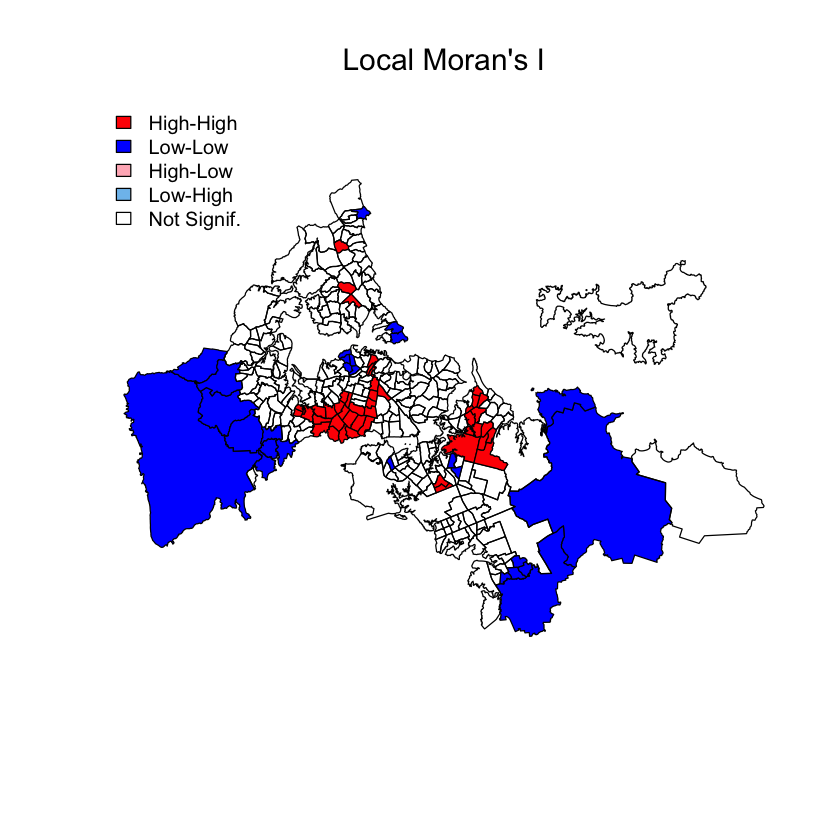

In [46]:

# Set the labeling for the map legend. These are the high-high, low-low etc 
# classes we calculated from the quadrants ealier.
labeling <- c("High-High", "Low-Low", "High-Low", "Low-High", "Not Signif.")

# Set the breaks for the thematic map classes
# We use the seq function to generation a sequence from 1-5, going up by 1.
num_breaks <- 1:6

# Define color swatches
pal <- c("red", "blue", "lightpink", "skyblue2", "white")


local_moran_cluster_map(auck, 'QUAD_SIG_ASI_P_06', num_breaks, labeling, colors, ttl="Local Moran's I")

### LISA Significance map

In [67]:
# The significance map made from the p values that localmoran() gave us.
# Reminder that the p values (significance) is column number 5 in locm
# We'll want to copy over the p-values from the locm results to our shapefile first
# So that we can map the values by color


local_moran_sig_map <- function (sf, 
                                 locm_table, 
                                 new_column_name, 
                                 plabels, breakpoints, num_breaks=5, 
                                 ttl="LISA Significance Map",
                                 palcolors="Greens") {
    # Make a column in auck data that has NA
    sf[[new_column_name]] <- NA
    
    # Populate LOCM_P with the results from locm function
    sf[[new_column_name]] <- locm_table[,5]
    sf[[new_column_name]]
    classes <- classIntervals(sf[[new_column_name]], num_breaks, style="fixed", fixedBreaks=breakpoints)
    
    #How many items do we have in each of our class intervals?
    print(classes)
    
    palette <- rev(brewer.pal(num_breaks, palcolors))
    colors <- findColours(classes, palette)

    # Generate the map
    plot(auck, col = colors, lwd=0.2, main=ttl)

    legend("topleft", legend = plabels, fill = palette, bty = "n")
    assign('auck',sf, envir=.GlobalEnv)

}


Warning message in classIntervals(sf[[new_column_name]], num_breaks, style = "fixed", :
“var has missing values, omitted in finding classes”

style: fixed
    [0,1e-04) [1e-04,0.001)  [0.001,0.01)   [0.01,0.05)      [0.05,1] 
           20             8            16            28           245 


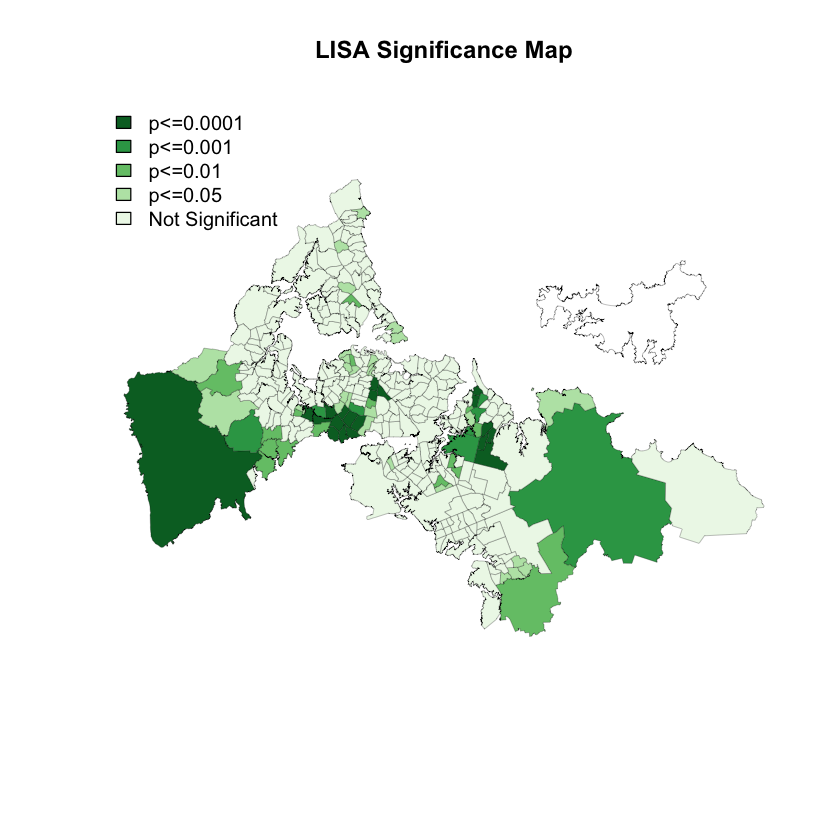

In [68]:
pval_labels <- c("p<=0.0001", "p<=0.001","p<=0.01", "p<=0.05","Not Significant")
pval_fixed_breaks <- c(1,0.05,0.01,0.001,0.0001,0)

#head(auck@data, n=10)
local_moran_sig_map(auck,
                    locm_asi_p_06,
                    'LOCM_ASI_P_06', 
                    pval_labels, 
                    pval_fixed_breaks, 
                    5, ttl="LISA Significance Map", "Greens")

# Questions + Deliverables

1. Determine the Moran’s I statistic for:
    - TB Rates 
    - Maori census groupings
    - Asian census groupings
    - Pacific Islander groupings
    - European groupings. 
  
2. For one (you choose) of the four major groupings perform the Univariate Local Moran’s
analysis. You should produce a Moran scatter plot, Significance map and Cluster map for this
analysis, and also a standard map (choose the map type you consider most informative)

3. Write a short report addressing the questions below:

    **Q1**:

    Compile a table of the Univariate Moran’s I results for each of the four major census groups. Which is most ‘aggregated’ based on these results? Do you think this result is very meaningful? Explain your answer with respect only to the statistical results, not the geographical distributions. 

    **Q2**:

    What correlation are there between the TB Rates and the census groupings? Are the TB Rates geographically clustered? 

    **Q3**:

    What changes to the Moran’s I approach might identify the difference among the groups more effectively? 
    [Hint: This is not an easy question, and you are not expected to come up with a definitive answer. Think about (among other things): scale, the census polygons being used, the total populations of each group, and how we are considering ‘near’ when we use polygon contiguity.